<a href="https://colab.research.google.com/github/SamuelTelesSilva/toxic_comment_detection/blob/main/notebooks/classifica%C3%A7%C3%A3o_de_texto_bin%C3%A1ria/treinando_bert_binario_OK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalação

In [ ]:
!pip install tensorflow
!pip install transformers
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Bibliotecas

In [ ]:
import pandas as pd
import seaborn as sns

import numpy as np
import tensorflow
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import scikitplot as skplt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import scikitplot as skplt

from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

#Usando BERT para classificação de texto

treinando um classificador de texto binário com BERT, keras e huggingface.

##Dataset

**Limpeza dos Dados**


coluna text_norm contém:
  - Separação palavras juntas
  - Corrigindo palavras incorretas com a biblioteca **enelvo**
  - retirando emojis com a biblioteca **emoji**
  - foi retirado as pontuações com **string.punctuation**
  - retirado as palavras vazias com **nltk.corpus.stopwords.words('portuguese')**
  - capitalização das palavras deixando tudo em caixa-baixa
  - colab com a normalização dos dados: https://colab.research.google.com/drive/1dHZXclbrZ9WsPCgHoVcMv0gmF2PgnUw-?usp=sharing

In [ ]:
PATH = "/content/drive/MyDrive/Pós-Graduação/Projeto de IA com Aprendizagem de Máquina/dataset/told_df_6.csv"

In [ ]:
told_br = pd.read_csv(PATH)

In [ ]:
#removendo a coluna unnamed
told_br.drop(told_br.columns[told_br.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [ ]:
told_br.head()

,text,text_norm,homophobia,obscene,insult,racism,misogyny,xenophobia,label,toxic
0,Meu nivel de amizade com isis é ela ter meu in...,nível amizade isis ter insta ter penso manda m...,0.0,0.0,2.0,0.0,0.0,0.0,Insult,1
1,"rt @user @user o cara adultera dados, que fora...",cara adultera dados desmascarados ainda quer f...,0.0,0.0,1.0,0.0,0.0,0.0,Insult,1
2,@user @user @user o cara só é simplesmente o m...,cara simplesmente maior vencedor história fute...,0.0,2.0,1.0,0.0,0.0,0.0,Obscene,1
3,eu to chorando vei vsf e eu nem staneio izone ...,to chorando velho vá foder enalteço ozone nada,0.0,1.0,0.0,0.0,0.0,0.0,Obscene,1
4,Eleitor do Bolsonaro é tão ignorante q não per...,eleitor bolsonaro tão ignorante percebeu frase...,0.0,1.0,2.0,0.0,0.0,0.0,Insult,1


In [ ]:
#alterando o tipo da coluna text_norm
told_br['text_norm'] = told_br['text_norm'].astype(str)

In [ ]:
told_br.shape

(21000, 10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


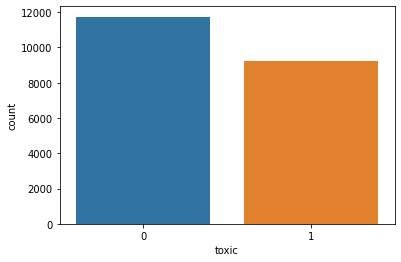

In [ ]:
sns.countplot(told_br['toxic']);

In [ ]:
np.unique(told_br['toxic'], return_counts=True)

(array([0, 1]), array([11745,  9255]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


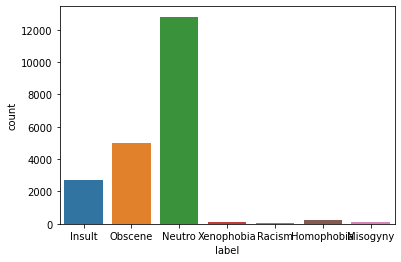

In [ ]:
sns.countplot(told_br['label']);

In [ ]:
np.unique(told_br['label'], return_counts=True)

(array(['Homophobia', 'Insult', 'Misogyny', 'Neutro', 'Obscene', 'Racism',
        'Xenophobia'], dtype=object),
 array([  207,  2730,    95, 12812,  5017,    54,    85]))

deixando apenas 5000 comentarios para fazer os testes

In [ ]:
told_br = told_br[0:5000]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


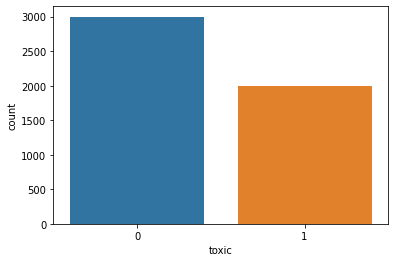

In [ ]:
sns.countplot(told_br['toxic']);

##Classificação de texto

In [ ]:
#Pegando os comentarios do dataset ja normalizados
sentences = told_br['text_norm']

#pegando as labels 0 e 1 do dataet
labels = told_br['toxic']

len(sentences),len(labels)

(5000, 5000)

Modelo BERT pré-treinado para o português do Brasil

https://huggingface.co/neuralmind/bert-base-portuguese-cased

In [ ]:
#transformers do huggingface
from transformers import BertTokenizer, TFBertModel

bert_tokenizer =\
BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

bmodel = TFBertModel.from_pretrained("neuralmind/bert-base-portuguese-cased", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [ ]:
input_ids = []

for sent in sentences:
   bert_inp = bert_tokenizer.encode_plus(
       sent,
       add_special_tokens = True,
       max_length = 64,
       pad_to_max_length = True,
       return_attention_mask = True)
   
   input_ids.append(bert_inp['input_ids'])

input_ids = np.asarray(input_ids)
labels = np.array(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids

array([[  101,  2270,  8286, ...,     0,     0,     0],
       [  101,  1354,  4183, ...,     0,     0,     0],
       [  101,  1354,  4877, ...,     0,     0,     0],
       ...,
       [  101,   240,   124, ...,     0,     0,     0],
       [  101,  5231, 22283, ...,     0,     0,     0],
       [  101,   240,   124, ...,     0,     0,     0]])

In [ ]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([2999, 2001]))

##Sobreamostragem (oversampling) - SMOTE

Class=1, n=2999 (50.000%)
Class=0, n=2999 (50.000%)


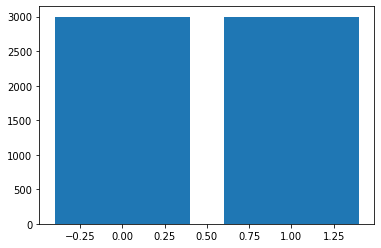

In [ ]:
# Encode do label
label_encode = LabelEncoder()
yz = label_encode.fit_transform(labels)

# transformando o dataset
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(input_ids, yz)

#distribuição
counter = Counter(y_over)
for k,v in counter.items():
	per = v / len(y_over) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
# plot distribuição
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([2999, 2001]))

In [ ]:
np.unique(y_over, return_counts=True)

(array([0, 1]), array([2999, 2999]))

##Classificação de texto continuação

In [ ]:
from sklearn.model_selection import train_test_split

X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X_over,
                                                                  y_over, 
                                                                  test_size = 0.2,
                                                                  stratify = y_over)

In [ ]:
X_treinamento.shape, X_teste.shape

((4798, 64), (1200, 64))

In [ ]:
inputs = Input(shape=(64,), dtype="int32")
bert = bmodel(inputs)
bert = bert[1]
outputs = Dense(units=1, activation="sigmoid")(bert)

In [ ]:
model = Model(inputs, outputs)
adam = tensorflow.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=adam)

In [ ]:
history = model.fit(x = X_treinamento,
          y = y_treinamento,
          batch_size=1,
          epochs=2,
          validation_split=0.2
          )

Epoch 1/2
3838/3838 [==============================] - 203s 50ms/step - loss: 0.5047 - accuracy: 0.7421 - val_loss: 0.3953 - val_accuracy: 0.8208
Epoch 2/2
3838/3838 [==============================] - 189s 49ms/step - loss: 0.3490 - accuracy: 0.8528 - val_loss: 0.4385 - val_accuracy: 0.8167


In [ ]:
bmodel.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108923136 
                                                                 
Total params: 108,923,136
Trainable params: 108,923,136
Non-trainable params: 0
_________________________________________________________________


**Avaliação do Modelo**

In [ ]:
predict = model.predict(X_teste) 
predict1 = predict.flatten()

In [ ]:
#extrair os rótulos de classe previstos
y_pred = np.where(predict1 > 0.5, 1, 0)
print(y_pred)

[0 1 1 ... 0 0 1]


Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.8757    0.7750    0.8223       600
           1     0.7982    0.8900    0.8416       600

    accuracy                         0.8325      1200
   macro avg     0.8370    0.8325    0.8319      1200
weighted avg     0.8370    0.8325    0.8319      1200

Acurácia: 0.8325

AUC: 0.8325



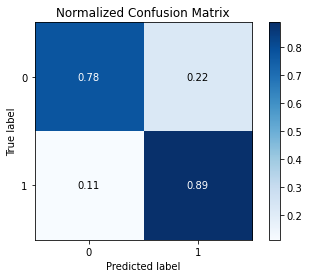

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste, y_pred, normalize=True)


# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste, y_pred)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_teste, y_pred)))

In [ ]:
# Testando a qualidade do modelo
test_loss, test_acc = model.evaluate(X_teste, y_teste)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

38/38 [==============================] - 8s 142ms/step - loss: 0.3929 - accuracy: 0.8325
Test Loss: 0.39288416504859924
Test Accuracy: 0.8324999809265137


- 1 - 0.8834951519966125 com o over e 1000 dados
- 2 - 0.78 5000 dados sem over
- 3 - 0.81 5000 dados com Over
- 4 - 0.8525 5000 dados com Over e epochs=2

**Testes com outros comentarios**

In [ ]:
texto1 = "você é um vadia"

In [ ]:
def entrada(texto):

  input_ids_1 = []

  bert_inp1 = bert_tokenizer.encode_plus(
  texto.lower(),
  add_special_tokens = True,
  max_length = 64,
  pad_to_max_length = True,
  return_attention_mask = True)
    
  input_ids_1.append(bert_inp1['input_ids'])

  input_ids_1 = np.asarray(input_ids_1)
  predict2 = model.predict(input_ids_1)

  predict2 = predict2.flatten()
  y_pred2 = np.where(predict2 > 0.5, 1, 0)

  return y_pred2


In [ ]:
entrada("não quero falar com você sua puta")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


array([1])